<center> <img src="https://upload.wikimedia.org/wikipedia/commons/e/e3/Booking.com_logo2.png" 
style="width:350px;height:80px"> </center>

# <center> Прогнозирование рейтинга отеля на Booking </center>
    
### <center> Какой кейс решаем? </center>  

Представим, что работаем дата-сайентистом в компании Booking. Одна из проблем компании — это нечестные отели, которые накручивают себе рейтинг. Одним из способов обнаружения таких отелей является построение модели, которая предсказывает рейтинг отеля. Если предсказания модели сильно отличаются от фактического результата, то, возможно, отель ведёт себя нечестно, и его стоит проверить.
    
<center> Описание данных

<table >
   <tr>
    <th>Признак</th>
    <th>Описание</th>
  </tr>
  
   <tr>
    <td>hotel_address</td>
    <td>street, post code, city, country </td>
  </tr>
    
   <tr>
    <td>additional_number_of_scoring</td>
    <td>the number of hotel scores without review </td>
  </tr> 
    
  <tr>
    <td>review_date</td>
    <td>the day of review </td>
  </tr>
    
  <tr>
    <td>average_score</td>
    <td>the average rating of the hotel </td>
  </tr>
    
   <tr>
    <td>hotel_name</td>
    <td>the full name of hotel </td>
  </tr>
    
   <tr>
    <td>reviewer_nationality</td>
    <td>country from which the reviewer came </td>
  </tr>
    
   <tr>
    <td>negative_review </td>
    <td>text of negative review </td>
  </tr> 
   
   <tr>
    <td>review_total_negative_word_counts </td>
    <td>the total number words of negative review </td>
  </tr>  
    
   <tr>
    <td>total_number_of_reviews </td>
    <td>the total number of reviews that the hotel has </td>
  </tr>  
    
   <tr>
    <td>positive_review</td>
    <td>text of positive review </td>
  </tr> 
    
   <tr>
    <td>review_total_positive_word_counts</td>
    <td>the total number words of positive review </td>
  </tr> 
    
  <tr>
    <td>total_number_of_reviews_reviewer_has_given</td>
    <td>the total number of reviews reviewer has given </td>
  </tr> 
    
   <tr>
    <td>reviewer_score</td>
    <td>the number of reviewer score </td>
  </tr> 
    
   <tr>
    <td>tags</td>
    <td>tags that describe purpose of trip,type of room, count of nights of reviewer </td>
  </tr> 
    
   <tr>
    <td>days_since_review</td>
    <td>a difference in the number of days between review date and scrape date</td>
  </tr> 
    
   <tr>
    <td>lat</td>
    <td>latitude coordinate of hotel location </td>
  </tr> 
    
   <tr>
    <td>lng</td>
    <td>longitude coordinate of hotel location </td>
  </tr> 
    
</table> </center>  
    

In [164]:
import pandas as pd
import numpy as np
import seaborn as sns
import statistics
import re
from collections import Counter
import matplotlib.pyplot as plt
import plotly
import plotly.express as px
import category_encoders as ce
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics 

In [165]:
!pip freeze > requirements.txt

In [ ]:
hotels_train = pd.read_csv('/kaggle/input/sf-booking/hotels_train.csv')
hotels_test = pd.read_csv('/kaggle/input/sf-booking/hotels_test.csv')
sample_submission = pd.read_csv('/kaggle/input/sf-booking/submission.csv')

In [166]:
# hotels_train = pd.read_csv('data/input/hotels_train.csv')
# hotels_test = pd.read_csv('data/input/hotels_test.csv')
# sample_submission = pd.read_csv('data/input/submission.csv')

### <center> Очистка данных </center>

Произведем очистку от дубликатов 

In [167]:
hotels_train.drop_duplicates(inplace=True)

Для того, чтобы привести обучающий и тестовый датасеты к единому виду, объединим их, но пометим отдельным признаком sample, чтобы была возможность разделить.

In [168]:
hotels_train['sample'] = 1 # помечаем тренировочный датасет
hotels_test['sample'] = 0 # помечаем тестовый датасет
hotels_test['reviewer_score'] = 0 # заполним признак 'reviewer_score' нулям, для того, чтобы можно было объединить

# обьединяем датасеты в один, для более удобной работы с одной датасетом, а не двумя.
data = pd.concat([hotels_train, hotels_test], ignore_index = True)

Проверим данные на наличие пропусков.

In [169]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 515431 entries, 0 to 515430
Data columns (total 18 columns):
 #   Column                                      Non-Null Count   Dtype  
---  ------                                      --------------   -----  
 0   hotel_address                               515431 non-null  object 
 1   additional_number_of_scoring                515431 non-null  int64  
 2   review_date                                 515431 non-null  object 
 3   average_score                               515431 non-null  float64
 4   hotel_name                                  515431 non-null  object 
 5   reviewer_nationality                        515431 non-null  object 
 6   negative_review                             515431 non-null  object 
 7   review_total_negative_word_counts           515431 non-null  int64  
 8   total_number_of_reviews                     515431 non-null  int64  
 9   positive_review                             515431 non-null  object 
 

Пропуски наблюдаются только в признаках 'lat' и 'lng'. При переборе среднего значения, медианы и моды, хоть и ненамного, но лучший результат получился при заполнении модой.

In [170]:
data['lat'] = data['lat'].fillna(statistics.mode(data['lat']))
data['lng'] = data['lng'].fillna(statistics.mode(data['lng']))

### <center> Исследование данных </center>

Посмотрим распределение оценок отелей, выставленых рецензетами. Данные выглядят правдоподобно, выбросов нет, основная часть оценок сосредоточена между 7.5 и 9.6.

In [171]:
fig = px.box(
    hotels_train,
    x='reviewer_score',
    title='Распределение оценок рецензентов',
    width=800,
    height=300
)

fig.show()

При просмотре статистических свойств остальных числовых признаков каких-то аномальных значений и выбросов тоже не обнаружено.

In [172]:
data.describe()

,additional_number_of_scoring,average_score,review_total_negative_word_counts,total_number_of_reviews,review_total_positive_word_counts,total_number_of_reviews_reviewer_has_given,reviewer_score,lat,lng,sample
count,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.000000,515431.00000
mean,498.275079,8.397630,18.539760,2744.259084,17.777342,7.165215,6.296715,49.455843,2.806004,0.74985
std,500.618961,0.548033,29.690973,2317.823718,21.803204,11.038742,3.902967,3.460175,4.571775,0.43310
min,1.000000,5.200000,0.000000,43.000000,0.000000,1.000000,0.000000,41.328376,-0.369758,0.00000
25%,169.000000,8.100000,2.000000,1161.000000,5.000000,1.000000,0.000000,48.214662,-0.143372,0.00000
50%,342.000000,8.400000,9.000000,2134.000000,11.000000,3.000000,7.900000,51.500732,-0.000250,1.00000
75%,660.000000,8.800000,23.000000,3633.000000,22.000000,8.000000,9.600000,51.516288,4.831098,1.00000
max,2682.000000,9.800000,408.000000,16670.000000,395.000000,355.000000,10.000000,52.400181,16.429233,1.00000


Ознакомимся с текстовыми признаками датасета.

In [173]:
data[[col for col in data.columns if data[col].dtype == 'object']].head(3)

,hotel_address,review_date,hotel_name,reviewer_nationality,negative_review,positive_review,tags,days_since_review
0,Stratton Street Mayfair Westminster Borough Lo...,2/19/2016,The May Fair Hotel,United Kingdom,Leaving,Staff were amazing,"[' Leisure trip ', ' Couple ', ' Studio Suite ...",531 day
1,130 134 Southampton Row Camden London WC1B 5AF...,1/12/2017,Mercure London Bloomsbury Hotel,United Kingdom,poor breakfast,location,"[' Business trip ', ' Couple ', ' Standard Dou...",203 day
2,151 bis Rue de Rennes 6th arr 75006 Paris France,10/18/2016,Legend Saint Germain by Elegancia,China,No kettle in room,No Positive,"[' Leisure trip ', ' Solo traveler ', ' Modern...",289 day


Посмотрим, какую информацию можно извлечь из текста позитивных и негативных отзывов. Для этого выведем 30 самых встреающихся значений. 

In [174]:
data['positive_review'].value_counts().index[:30]

Index(['No Positive', ' Location', ' Everything', ' location', ' Nothing',
       ' The location', ' Great location', ' Good location', ' Location ',
       ' Everything ', ' Breakfast', ' Friendly staff', ' Staff',
       ' Excellent location', ' Great location ', ' Location and staff',
       ' everything', ' Good location ', ' Nothing ', ' Comfy bed', ' nothing',
       ' The location ', ' good location', ' The staff', ' Good breakfast',
       ' ', ' Location staff', ' the location', ' Location was great',
       ' Location was good'],
      dtype='object', name='positive_review')

In [175]:
data['negative_review'].value_counts().index[:30]

Index(['No Negative', ' Nothing', ' Nothing ', ' nothing', ' N A', ' None',
       ' ', ' N a', ' Breakfast', ' Small room', ' Location', ' Everything',
       ' All good', ' Nothing really', ' none', ' nothing ', ' No complaints',
       ' Price', ' Nothing really ', ' Nil', ' n a', ' Nothing at all',
       ' Nothing to dislike', ' Nothing at all ', ' Small rooms', ' None ',
       ' No complaints ', ' All good ', ' NA', ' Expensive'],
      dtype='object', name='negative_review')

### <center> Генерация признаков </center>

Так как самыми популяными значениями позитивных и негативных отзывов является их отсутствие, то сформируем отдельный признак отсутствия соответстсвующего отзыва.

In [176]:
no_positive_review = ['No Positive', ' Nothing', ' Nothing ', ' nothing', ' ']
no_negative_review = ['No Negative', ' Nothing', ' Nothing ', ' nothing', 
                      ' N A', ' None', ' ', ' N a', ' none', ' nothing ', 
                      ' n a', ' Nothing at all', ' Nothing to dislike', 
                      ' Nothing at all ', ' None ', ' All good ', ' NA']

data['no_positive_review'] = data['positive_review'].apply(lambda x: 1 if x in no_positive_review else 0)
data['no_negative_review'] = data['negative_review'].apply(lambda x: 1 if x in no_positive_review else 0)

Из даты раземещия отзыва извлекем день, месяц и год.

In [177]:
data['review_date'] = pd.to_datetime(data['review_date'])
data['month']=pd.to_datetime(data['review_date']).dt.month
data['year']=pd.to_datetime(data['review_date']).dt.year
data['day']=pd.to_datetime(data['review_date']).dt.day

Из признака тегов сгенерируем новые признаки: 'nights' - количество ночей, проведенных в отеле, а также 20 самых часто встречающихся тегов выведем в отдельные признаки.

In [178]:
tag_uniq_set = set() # множество уникальных тегов датафрейма
tag_list = list() # список абсолютно всех тегов датафрейма
nights_list = list() # список количества проведенных ночей всех записей датафрейма
tag_cell_list = list() # список тегов всех записей датафрейма (список списков тегов)

for i in range(data.shape[0]): # цикл по всем строкам датафрейма
    cell = re.findall("' (.*?) '", data['tags'].iloc[i]) # список тегов одной записи
    tag_cell_list.append(cell) # список тегов одной записи добавляем в общий спиок по строкам
    nights_frase = re.search('tayed (\d+) night', data['tags'].iloc[i]) # выявляем тег о кол-ве ночей
    if nights_frase: # если он есть
        nights = int(re.search('\d+', nights_frase.group(0)).group(0)) # выделяем кол-во ночей
    else:
        nights = None
    nights_list.append(nights) # кол-во ночей каждой записи добавляем в общий список ночей
    for j in cell: # цикл по тегам одной записи
        tag_uniq_set.add(j) # пополняем множество уникальных тегов датафрейма
        if 'Stayed' not in j: # отсеиваем теги с проведенными ночами (они будут отдельными признаками)
            tag_list.append(j)
        
counter_tags = Counter(tag_list) # считаем количество повторений каждого тега
common_tags_count = counter_tags.most_common(20) # самые популярные 20 тегов таблицы

nigts_ser = pd.Series(data=nights_list, name='nights') # серия с количествами проведенных ночей
data = pd.concat([data, nigts_ser], axis=1) # добавляем серию как новый признак
data['nights'] = data['nights'].fillna(statistics.mode(data['nights']))
data['nights'] = data['nights'].astype('int8')

common_tags = list() # список самых популярных тегов
for i in common_tags_count:
    common_tags.append(i[0])
 
tags_dict = dict() # ключ - будущий признак (тег), значение - список с 0 и 1 соответсвия тегу

for i in common_tags: # цикл по списку самых популярных тегов
    temp_list = list() # список с будущими 0 и 1 признака
    for j in tag_cell_list: # цикл по спискам тегов одной строки
        bit = 1 if i in j else 0
        temp_list.append(bit)
    tags_dict[i] = temp_list
    
features = pd.DataFrame(tags_dict) # датафрейм с новыми признаками

data = pd.concat([data, features], axis=1) # добавление новых признаков к основному датафрейму

### <center> Преобразование признаков </center>

Признаки адреса отеля и его название будут сильно коррелировать друг с другом, но более уникальным является адрес, поэтому далее будем работать только с ним, а название отбросим.  
К признакам страны рецензента, адреса и географических координат применим порядковое кодирование.

In [179]:

ord_encoder = ce.OrdinalEncoder(cols=['reviewer_nationality', 'hotel_address','lat', 'lng'])
rew_nat = ord_encoder.fit_transform(data[['reviewer_nationality', 'hotel_address','lat', 'lng']])
data.drop(['reviewer_nationality', 'hotel_address','lat', 'lng'], axis = 1, inplace=True)
data = pd.concat([data, rew_nat], axis=1)

Признак количества дней между датой проверки и датой очистки приведем к числовому типу.

In [180]:

data['days_since_review'] = data['days_since_review'].apply(lambda x: x.split()[0]).astype('int64')

### <center> Отбор признаков </center>

Удалим текстовые признаки, а также признак даты выставления оценки.

In [181]:
# модель на признаках с dtypes "object" обучаться не будет, просто выберем их и удалим
object_columns = [s for s in data.columns if data[s].dtypes == 'object']
data.drop(object_columns, axis = 1, inplace=True)

data.drop('review_date', axis = 1, inplace=True)

Разделим обратно общий датасет на части для обучения и тестирования, чтобы по можно было оценить степень значимости каждого из них.

In [182]:
hotels_train = data[data['sample'] == 1]
hotels_train.drop(['sample'], axis=1, inplace=True)

hotels_test = data[data['sample'] == 0]
hotels_test.drop(['sample', 'reviewer_score'], axis=1, inplace=True)

C:\Users\UserOK\AppData\Local\Temp\ipykernel_1160\3838870658.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\UserOK\AppData\Local\Temp\ipykernel_1160\3838870658.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [183]:
# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели  
# Х - данные с информацией об отелях, у - целевая переменная (рейтинги отелей)  
X = hotels_train.drop(['reviewer_score'], axis = 1)  
y = hotels_train['reviewer_score'] 

Разделяем все признаки датасета на категориальные и непрерывные.

In [184]:
# непрерывные признаки
num_cols = ['additional_number_of_scoring','average_score', 'days_since_review',
    'review_total_negative_word_counts', 'total_number_of_reviews',
    'review_total_positive_word_counts', 'total_number_of_reviews_reviewer_has_given']

# категориальные признаки
cat_cols = list(X.columns)

for col in num_cols:
    cat_cols.remove(col)

Построим матрицу корреляции категориальных признаков.

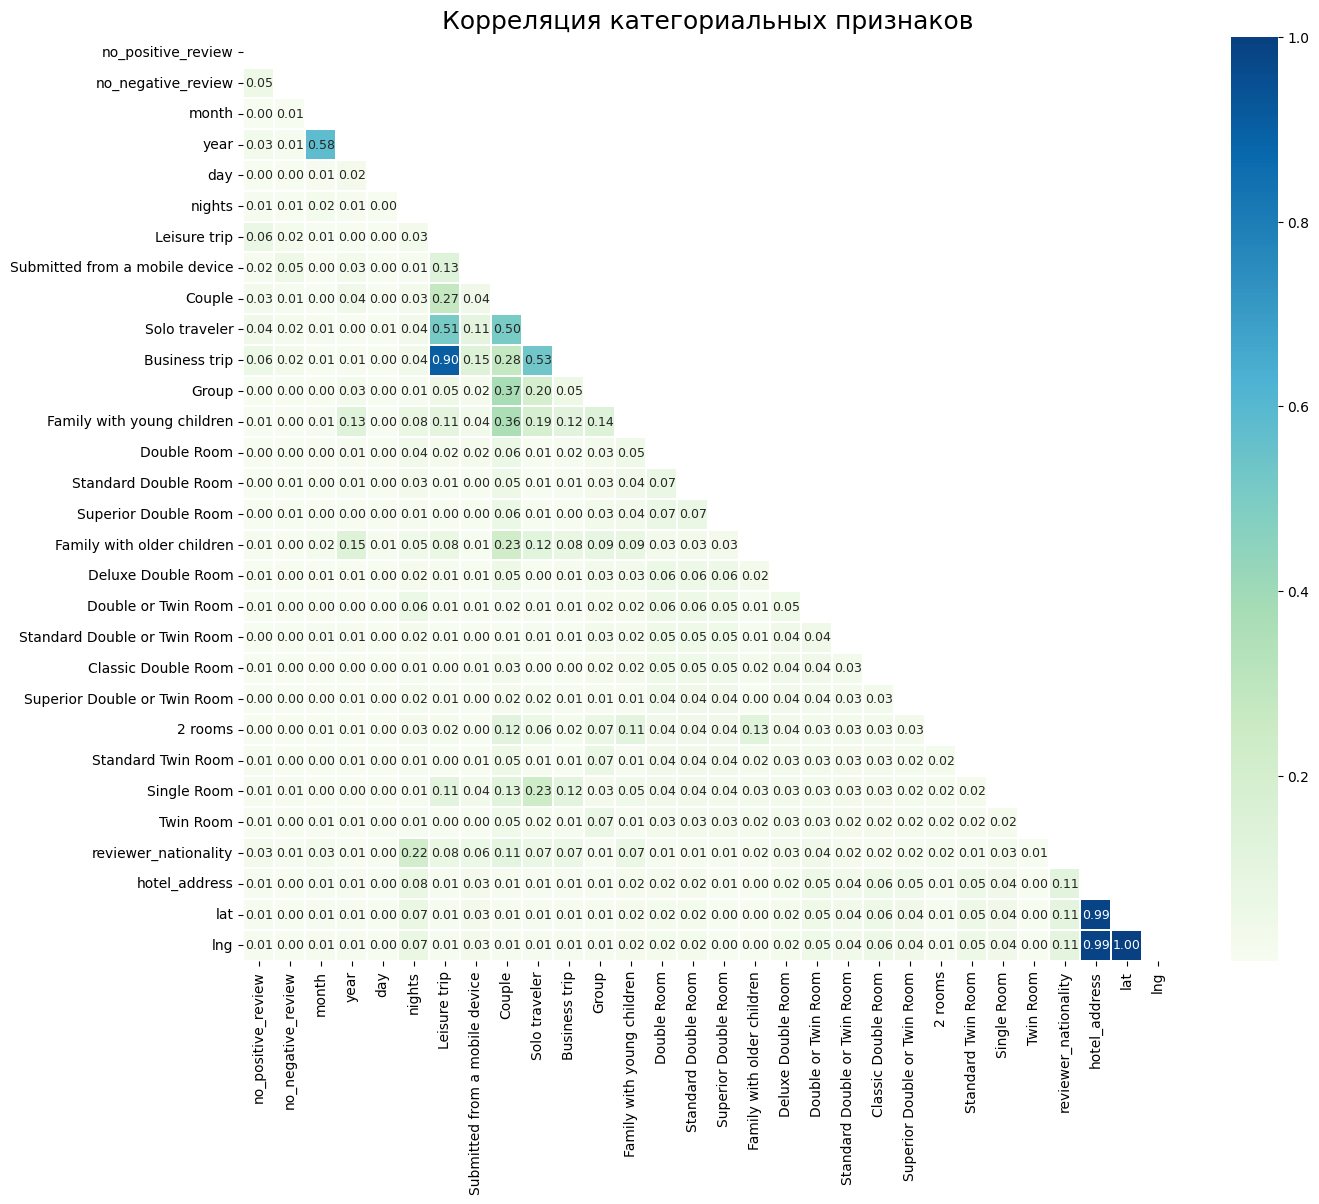

In [185]:
fig_, ax_ = plt.subplots(figsize=(15, 12))
corr = X[cat_cols].corr().abs()
matrix = np.triu(X[cat_cols].corr())
sns.heatmap(corr, 
            annot=True,
            annot_kws={"fontsize":9}, 
            linewidths=0.1, 
            ax=ax_, 
            mask=matrix, 
            cmap='GnBu',
            fmt='.2f')
ax_.set_title('Корреляция категориальных признаков', 
                  fontsize=18)
plt.show()

Создадим список признаков, которые необходимо удалить, и добавим в него географические координаты, а также признак тега "деловая поездка", обладающие мультиколлинеарностью с другими признаками и друг с другом.
Удалим эти признаки из обучающего, тестового датасетов и списка категориальных признаков.

In [186]:
drop_list = ['lat', 'lng', 'Business trip']

X.drop(drop_list, axis = 1, inplace=True)
hotels_test.drop(drop_list, axis = 1, inplace=True)

for col in drop_list:
    cat_cols.remove(col)

C:\Users\UserOK\AppData\Local\Temp\ipykernel_1160\947587268.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Для оценки значимости категориальных переменных будем использовать непараметрический тест хи-квадрат и представим результат в виде графика.

<Axes: >

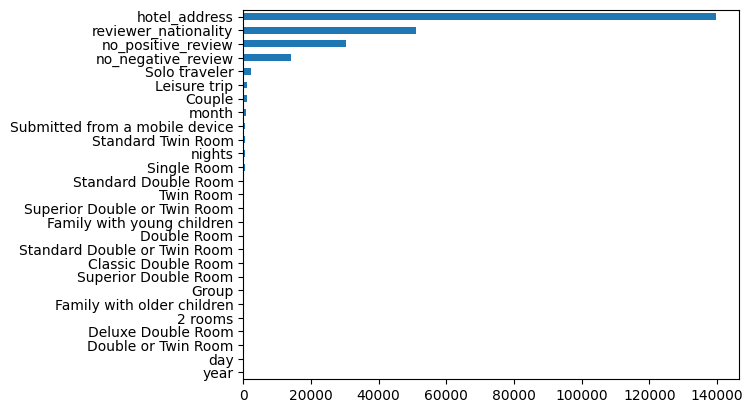

In [187]:
y_int = y.astype('int')

imp_cat = pd.Series(chi2(X[cat_cols], y_int)[0], index=cat_cols)
imp_cat.sort_values(inplace = True)
imp_cat.plot(kind = 'barh')

Отсеим самые малозначимые признаки по количесственному значению статистики, удалив все признаки со значением менее 400.

In [188]:
imp_cat

year                                   0.055663
day                                   37.471570
Double or Twin Room                   40.336644
Deluxe Double Room                    42.060173
2 rooms                               73.953609
Family with older children            85.298643
Group                                 97.835647
Superior Double Room                 110.834592
Classic Double Room                  125.006913
Standard Double or Twin Room         126.511264
Double Room                          152.533332
Family with young children           186.371642
Superior Double or Twin Room         201.590501
Twin Room                            247.480920
Standard Double Room                 273.565180
Single Room                          391.361597
nights                               435.493427
Standard Twin Room                   506.546898
Submitted from a mobile device       624.603036
month                                731.116137
Couple                               998

In [189]:
drop_list = list(imp_cat[imp_cat < 400].index)

Для оценки значимости непрерывных переменных будем использовать функцию f_classif, в основе которой анализ ANOVA.

<Axes: >

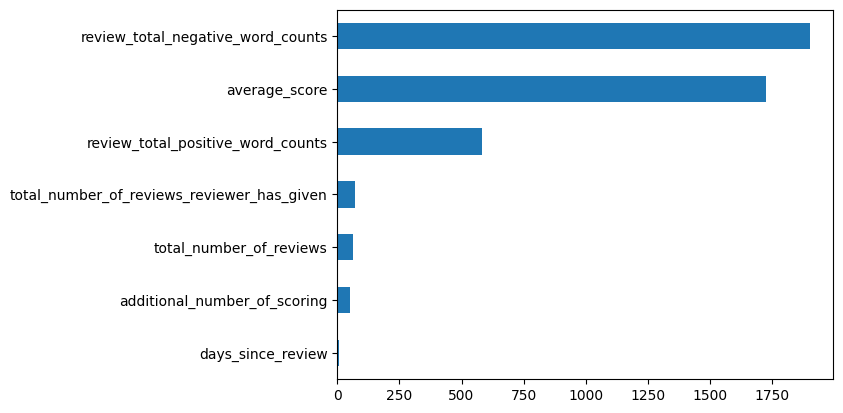

In [190]:
imp_num = pd.Series(f_classif(X[num_cols], y)[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

Из непрерывных признаков ввиду их малого количества удалим только самый малозначимый.

In [191]:
drop_list.append('days_since_review')

Удалим выбранные признаки из обучающего и тестового датасетов.

In [192]:
X.drop(drop_list, axis = 1, inplace=True)
hotels_test.drop(drop_list, axis = 1, inplace=True)

C:\Users\UserOK\AppData\Local\Temp\ipykernel_1160\486551638.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



### <center> Обучение модели </center>

In [193]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.  
# Для тестирования мы будем использовать 25% от исходного датасета.  
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [194]:
# Создаём модель  
regr = RandomForestRegressor(n_estimators=100)  
      
# Обучаем модель на тестовом наборе данных  
regr.fit(X_train, y_train)  
      
# Используем обученную модель для предсказания рейтинга отелей в нашей тестовой выборке.  
# Предсказанные значения записываем в переменную y_pred 
y_pred = regr.predict(X_test)

In [195]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они отличаются  
# Метрика называется Mean Absolute Percentage Error (MAPE) и показывает среднюю абсолютную процентную ошибку предсказанных значений от фактических.  
mape = {'MAPE': metrics.mean_absolute_percentage_error(y_test, y_pred)}
print(mape)

{'MAPE': 0.13421190400254596}


In [196]:
# Используем обученную модель для предсказания рейтинга отелей в тестовой выборке для получения сабмита
predict_submission = regr.predict(hotels_test)

In [197]:
# Сохраним полученный сабмит для участия в соревновании
sample_submission['reviewer_score'] = predict_submission
sample_submission.to_csv('data/output/submission.csv', index=False)